In [ ]:
# Github Link : https://github.com/AnkitaSavaliya/AIH/blob/main/MIMIC_III_NLP.ipynb

In [1]:
import pandas as pd
from google.cloud import bigquery

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install spacy==3.7.5
!pip install scispacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_md-0.5.4.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_ner_bc5cdr_md-0.5.4.tar.gz
!pip install transformers

### Fetching and Filtering Data of noteevents

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

!gcloud projects list

from google.cloud import bigquery

# Construct a BigQuery client object.
client = bigquery.Client(project='clinical-entity-extraction')

"""
ICD codes related to Hypertension:
 4010 - Malignant essential hypertension
 4011 - Benign essential hypertension
 4019 - Unspecified essential hypertension
"""
# Fetch notes only for ICD-9 code 4010(Malignant essential hypertension)
query = """
   SELECT SUBJECT_ID, TEXT, CATEGORY
    FROM `physionet-data.mimiciii_notes.noteevents`
    WHERE SUBJECT_ID IN (
        SELECT d.SUBJECT_ID
        FROM `physionet-data.mimiciii_clinical.diagnoses_icd` d
        WHERE d.ICD9_CODE = '4010' -- Hypertension code
        AND d.SEQ_NUM = 1  -- Assuming 1 indicates primary diagnosis
    )
    AND CATEGORY LIKE 'Discharge summary';
"""

# Run the query
query_job = client.query(query)

# Print the results
noteevents_df = query_job.to_dataframe()

len(noteevents_df)

Authenticated
PROJECT_ID                  NAME                        PROJECT_NUMBER
clinical-entity-extraction  clinical-entity-extraction  321960627270


162

In [ ]:
patients_dict = {"SUBJECT_ID":[],"CATEGORY":[],"TEXT":[]};
for i in range(0, len(noteevents_df)):
   patients_dict["SUBJECT_ID"].append(noteevents_df.loc[i, 'SUBJECT_ID'])
   patients_dict["CATEGORY"].append(noteevents_df.loc[i, 'CATEGORY'])
   patients_dict["TEXT"].append(noteevents_df.loc[i, 'TEXT'])

patients_df = pd.DataFrame(patients_dict)

In [ ]:
patients_df.shape

(162, 3)

In [ ]:
#print first few records
patients_df.head(2)

In [ ]:
# Download the patients_df dataframe in .csv and excel format
patients_df.to_csv(r'Patient_Summary_4010.csv', index = False)
patients_df.to_excel("Patient_Summary_4010.xlsx")

In [ ]:
# Copy Processed data to google drive
!cp 'Patient_Summary_4010.csv' '/content/drive/MyDrive/Colab Notebooks/AIH/Patient_Summary_4010.csv'
!cp 'Patient_Summary_4010.xlsx' '/content/drive/MyDrive/Colab Notebooks/AIH/Patient_Summary_4010.xlsx'

### Functions to clean text and extract tokens and entities.

In [ ]:
! python -m spacy download en_core_web_sm

In [5]:
import spacy

# Function to clean and extract tokens
def extract_cleaned_text(text, nlp_model):
    doc = nlp_model(str(text))
    tokens = [token.text for token in doc if not token.is_punct and not token.is_space and not token.is_stop]
    return " ".join(tokens)  # Return cleaned text as a string

In [6]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

def tsne_plot(model, words, words_limit = None, model_title="", preTrained=False):
    """
    Creates and displays two t-SNE plots:
    1. Simple scatter plot with labels.
    2. Scatter plot with distance-based coloring.

    Parameters:
    - model: The Word2Vec model or pre-trained model.
    - words: List of words to visualize.
    - words_limit : Limit the number of words to visualize.
    - model_title: Title of the model.
    - preTrained: Boolean flag to choose between Word2Vec or pre-trained model.
    """
    labels = []
    tokens = []

    # Apply t-SNE for dimensionality reduction
    tsne_model = TSNE(perplexity=30, early_exaggeration=12, n_components=2, init='pca', max_iter=1000, random_state=23)

    # Prepare tokens and labels
    for word in words[:words_limit]:
        if preTrained:
            tokens.append(model[word])  # Pre-trained word vectors
        else:
            tokens.append(model.wv[word])  # Word2Vec model vectors
        labels.append(word)

    tokens = np.array(tokens)
    new_values = tsne_model.fit_transform(tokens)

    x = new_values[:, 0]
    y = new_values[:, 1]

    # First plot: Scatter plot with annotations
    plt.figure(figsize=(16,12))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.title(f"t-SNE Visualization for {model_title}")
    plt.show()

In [7]:
import spacy

def build_corpus(df, model="en_core_web_sm"):
    """
    Extracts named entities from the specified text column in a DataFrame using a spaCy model,
    builds a corpus.

    Parameters:
    - df (pd.DataFrame): DataFrame containing text data.
    - text_column (str): Column name containing processed text.
    - model (str): spaCy model to use (default: "en_core_web_sm").

    Returns:
    - corpus (list of lists): Extracted entities per document.
    """
    nlp = model
    corpus = []

    for _, row in df.iterrows():
        tokens = [ent.text for ent in nlp(row["Processed_Text"]).ents]
        corpus.append(tokens)

    # Calculate word counts
    word_counts = [len(doc) for doc in corpus]

    return corpus

## Using Spacy

In [ ]:
import pandas as pd

#Load Patient Discharge summary
patients_df_scapy = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AIH/Patient_Summary_4010.csv")

# Load the spacy model
nlp_spacy = spacy.load('en_core_web_sm')

# Apply token extraction
patients_df_scapy["Processed_Text"] = patients_df_scapy["TEXT"].apply(lambda text: extract_cleaned_text(text, nlp_spacy))

#Copy Processed data to google drive
patients_df_scapy.to_csv(r'Patient_Summary_4010_Spacy.csv', index = False)
!cp 'Patient_Summary_4010_Spacy.csv' '/content/drive/MyDrive/Colab Notebooks/AIH/Patient_Summary_4010_Spacy.csv'

In [6]:
import pandas as pd
# Load the processed patient data with spacy
patients_df_scapy = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AIH/Patient_Summary_4010_Spacy.csv")

nlp_spacy = spacy.load('en_core_web_sm')  # Load the specified NLP model

In [ ]:
doc = nlp_spacy( patients_df_scapy['Processed_Text'][0])
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

In [ ]:
from spacy import displacy

# Visualize named entities using displacy
for i in range(0, len(patients_df_scapy)):
    doc = nlp_spacy( patients_df_scapy['Processed_Text'][i])
    displacy.render(doc, style="ent")
    print("*************************")


*************************


### Word2Vec and t-SNE Visualization Using SpaCy-Processed Data

In [ ]:
from gensim.models import Word2Vec

#Build corpus
corpus_spacy = build_corpus(patients_df_scapy, nlp_spacy)

In [ ]:
model_word2vec_spacy = Word2Vec(corpus_spacy, min_count=3, window=2, vector_size=100)

In [ ]:
model_word2vec_spacy.wv.similar_by_key("BP"), model_word2vec_spacy.wv.similar_by_key("Clonidine")

([('CT', 0.9996870160102844),
  ('ICU', 0.9996408820152283),
  ('EKG', 0.9996089935302734),
  ('MICU', 0.9996005296707153),
  ('CK', 0.9995817542076111),
  ('Known', 0.9995751976966858),
  ('18', 0.9995639324188232),
  ('27', 0.9995404481887817),
  ('IV', 0.9995347261428833),
  ('INR', 0.999534010887146)],
 [('3', 0.9992740154266357),
  ('100', 0.9992536306381226),
  ('PO', 0.999226987361908),
  ('BP', 0.9992194175720215),
  ('90', 0.9992076754570007),
  ('25', 0.9991985559463501),
  ('EKG', 0.9991586804389954),
  ('30', 0.9991428256034851),
  ('CT', 0.9991336464881897),
  ('18', 0.9991272687911987)])

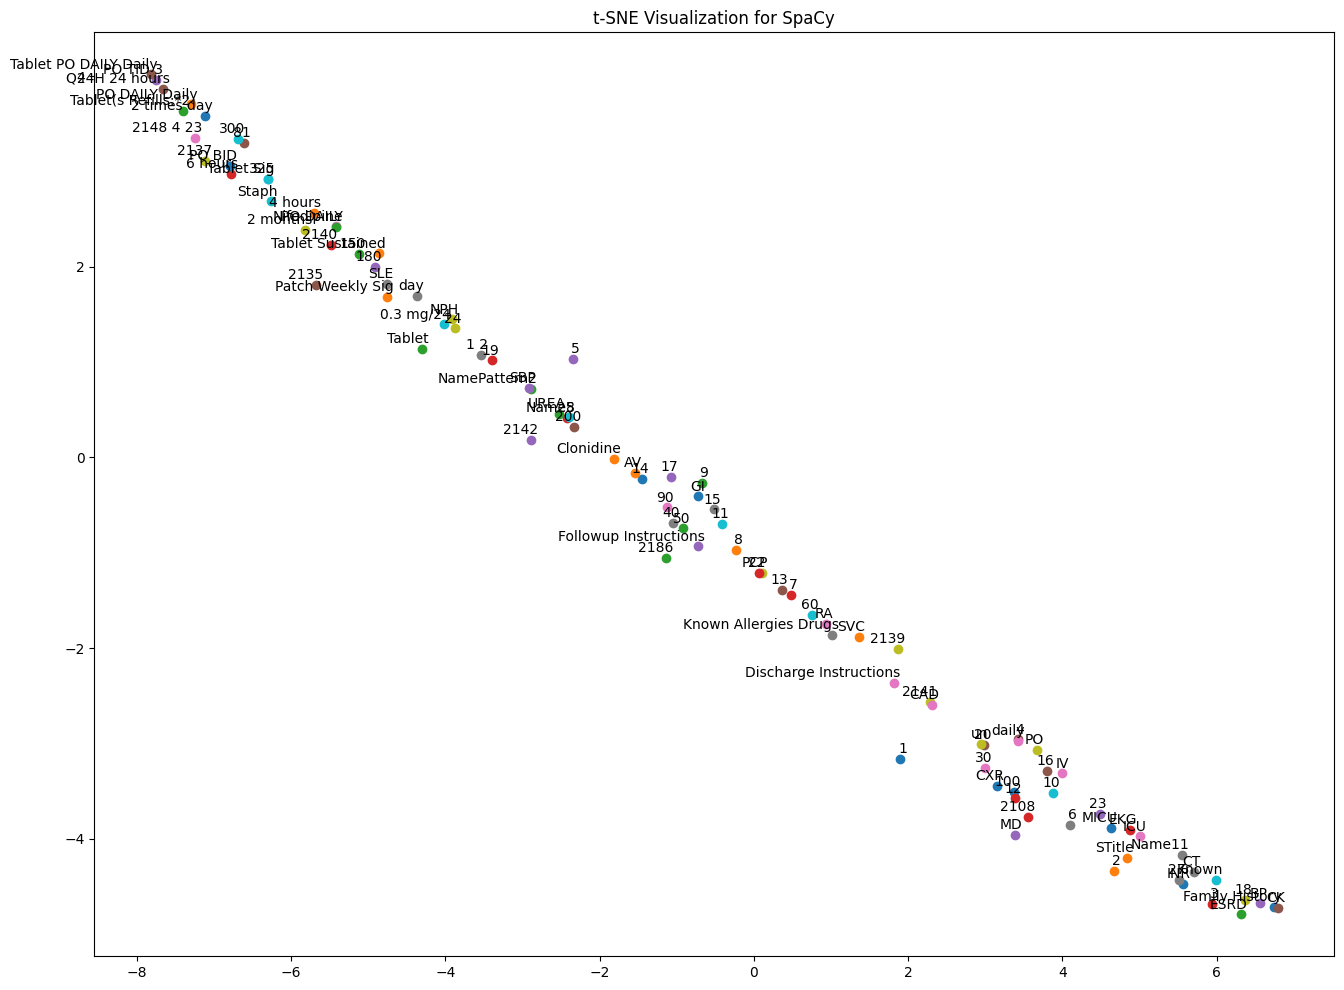

In [ ]:
tsne_plot(model_word2vec_spacy, np.array(list(model_word2vec_spacy.wv.key_to_index.keys())), 100, 'SpaCy')

## Using SciSpacy


In [ ]:
import pandas as pd
import scispacy
import spacy

#Load Patient Discharge summary
patients_df_SciSpaCy = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AIH/Patient_Summary_4010.csv")

nlp_SciSpaCy = spacy.load('en_core_sci_md')  # Load the specified NLP model
# Apply token extraction
patients_df_SciSpaCy["Processed_Text"] = patients_df_SciSpaCy["TEXT"].apply(lambda text: extract_cleaned_text(text, nlp_SciSpaCy))

#Copy Processed data to google drive
patients_df_SciSpaCy.to_csv(r'Patient_Summary_4010_SciSpacy.csv', index = False)
!cp 'Patient_Summary_4010_SciSpacy.csv' '/content/drive/MyDrive/Colab Notebooks/AIH/Patient_Summary_4010_SciSpacy.csv'

In [2]:
import pandas as pd
import scispacy
import spacy

nlp_SciSpaCy = spacy.load('en_core_sci_md')

#Load Processed SciSpacy
patients_df_SciSpaCy = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AIH/Patient_Summary_4010_SciSpacy.csv")

In [ ]:
from spacy import displacy
# Visualize named entities using displacy
for i in range(0, len(patients_df_SciSpaCy)):
    doc = nlp_SciSpaCy( patients_df_SciSpaCy['Processed_Text'][i])
    displacy.render(doc, style="ent", jupyter=True)
    print("**************************************")

**************************************


### Word2Vec and t-SNE Visualization Using SciSpaCy-Processed Data

In [ ]:
from gensim.models import Word2Vec

corpus_scispacy = build_corpus(patients_df_SciSpaCy, nlp_SciSpaCy)

In [ ]:
model_word2vec_scispacy = Word2Vec(corpus_scispacy, min_count=3, window=2, vector_size=100)

In [ ]:
model_word2vec_scispacy.wv.similar_by_key("BP"), model_word2vec_scispacy.wv.similar_by_key("Clonidine")

([('RA', 0.9994686245918274),
  ('ED', 0.999396562576294),
  ('HR', 0.9993236660957336),
  ('MICU', 0.9991095662117004),
  ('treated', 0.9991006851196289),
  ('patient', 0.9990440011024475),
  ('elevated', 0.998954713344574),
  ('baseline', 0.9989470839500427),
  ('O2', 0.9989447593688965),
  ('RR', 0.9989378452301025)],
 [('Patch', 0.9970031380653381),
  ('Prednisone', 0.9962016940116882),
  ('HCl', 0.9951486587524414),
  ('Tablet Sig 1 Tablet PO', 0.9949968457221985),
  ('Labetalol', 0.9949793815612793),
  ('Refills:*0', 0.9945780038833618),
  ('Amlodipine', 0.9940680265426636),
  ('Metoprolol', 0.9939988851547241),
  ('Aspirin', 0.9939936995506287),
  ('Acetaminophen', 0.9935530424118042)])

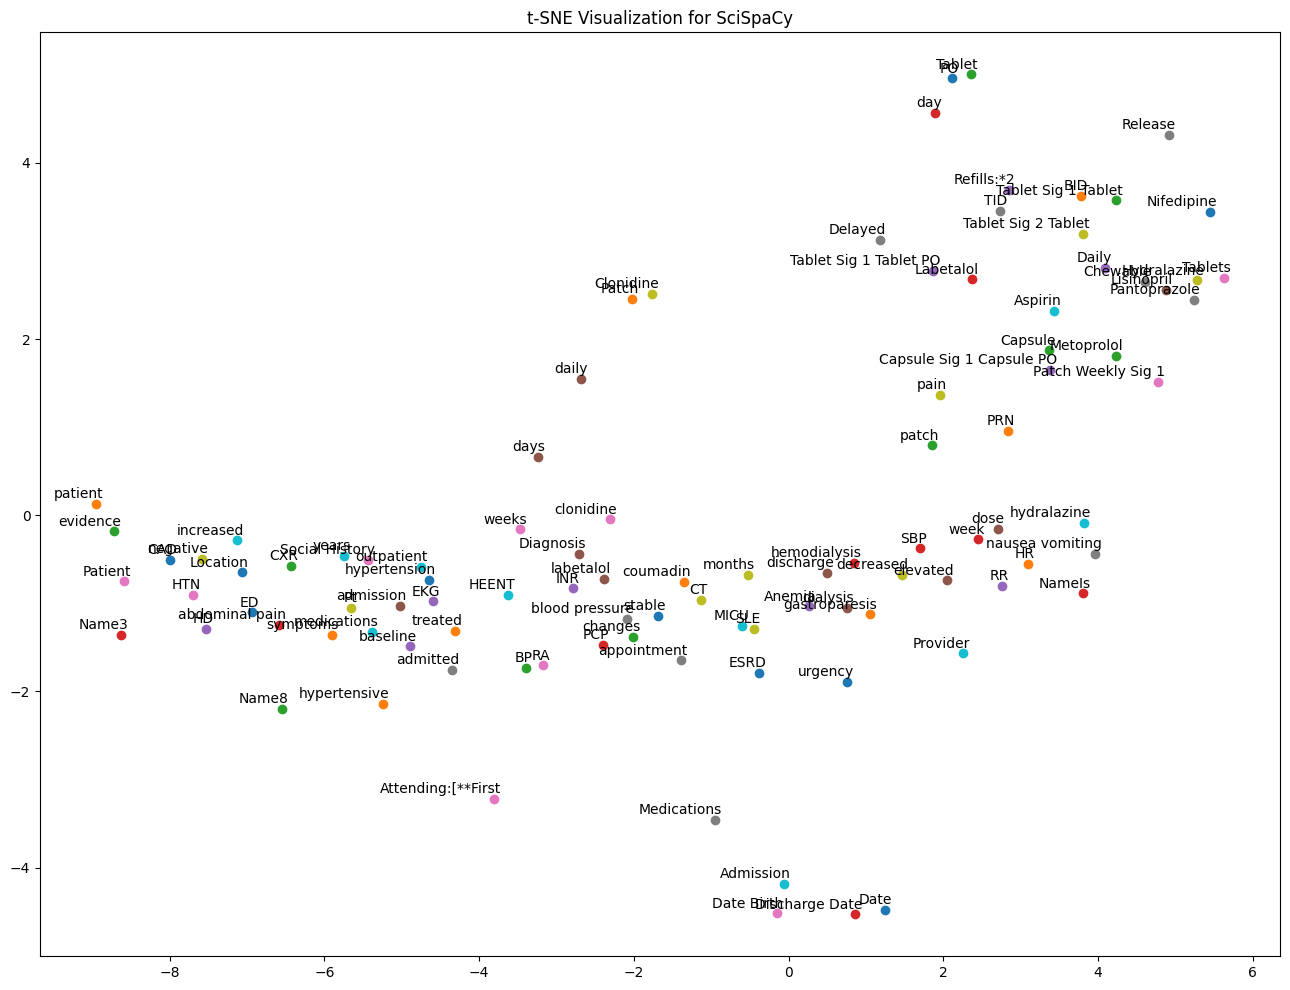

In [ ]:
tsne_plot(model_word2vec_scispacy, np.array(list(model_word2vec_scispacy.wv.key_to_index.keys())), 100, 'SciSpaCy')


### en_ner_bc5cdr_md Visualization Using SciSpaCy-Processed Data.
  
*   It is a SciSpaCy model, not a standard SpaCy model. It is specifically trained for biomedical named entity recognition (NER), focusing on diseases and chemicals.

In [ ]:
import en_ner_bc5cdr_md
import spacy
from spacy import displacy

nlp__bc5cdr = en_ner_bc5cdr_md.load()

# Visualize named entities using displacy
for i in range(0, len(patients_df_SciSpaCy)):
    doc = nlp__bc5cdr( patients_df_SciSpaCy['Processed_Text'][i])
    displacy.render(doc, style="ent", jupyter=True)
    print("**************************************")


**************************************


In [ ]:
from gensim.models import Word2Vec
corpus_bc5cdr = build_corpus(patients_df_SciSpaCy, nlp__bc5cdr)

In [ ]:
model_word2vec_bc5cdr = Word2Vec(corpus_bc5cdr, min_count=3, window=2, vector_size=100)

In [ ]:
model_word2vec_bc5cdr.wv.similar_by_word("BP"), model_word2vec_bc5cdr.wv.similar_by_word("Clonidine")

([('MSSA bacteremia', 0.8200060129165649),
  ('Metoprolol Succinate', 0.8162233233451843),
  ('dementia', 0.8155735731124878),
  ('fungal infection', 0.8151078820228577),
  ('diabetes brothers diabetes', 0.813332200050354),
  ('lasix', 0.8124308586120605),
  ('Levofloxacin', 0.8123695850372314),
  ('Diabetic ketoacidosis', 0.8123500347137451),
  ('seizure', 0.8114094734191895),
  ('EtOH', 0.810998797416687)],
 [('Labetalol', 0.9987290501594543),
  ('Lisinopril', 0.9986595511436462),
  ('pain', 0.9986243844032288),
  ('hypertensive', 0.9986111521720886),
  ('hypertension', 0.9985666871070862),
  ('HTN', 0.9985529184341431),
  ('Aspirin', 0.9985363483428955),
  ('chest pain', 0.9984893202781677),
  ('Tablet(s', 0.9984655380249023),
  ('Metoclopramide', 0.9984307885169983)])

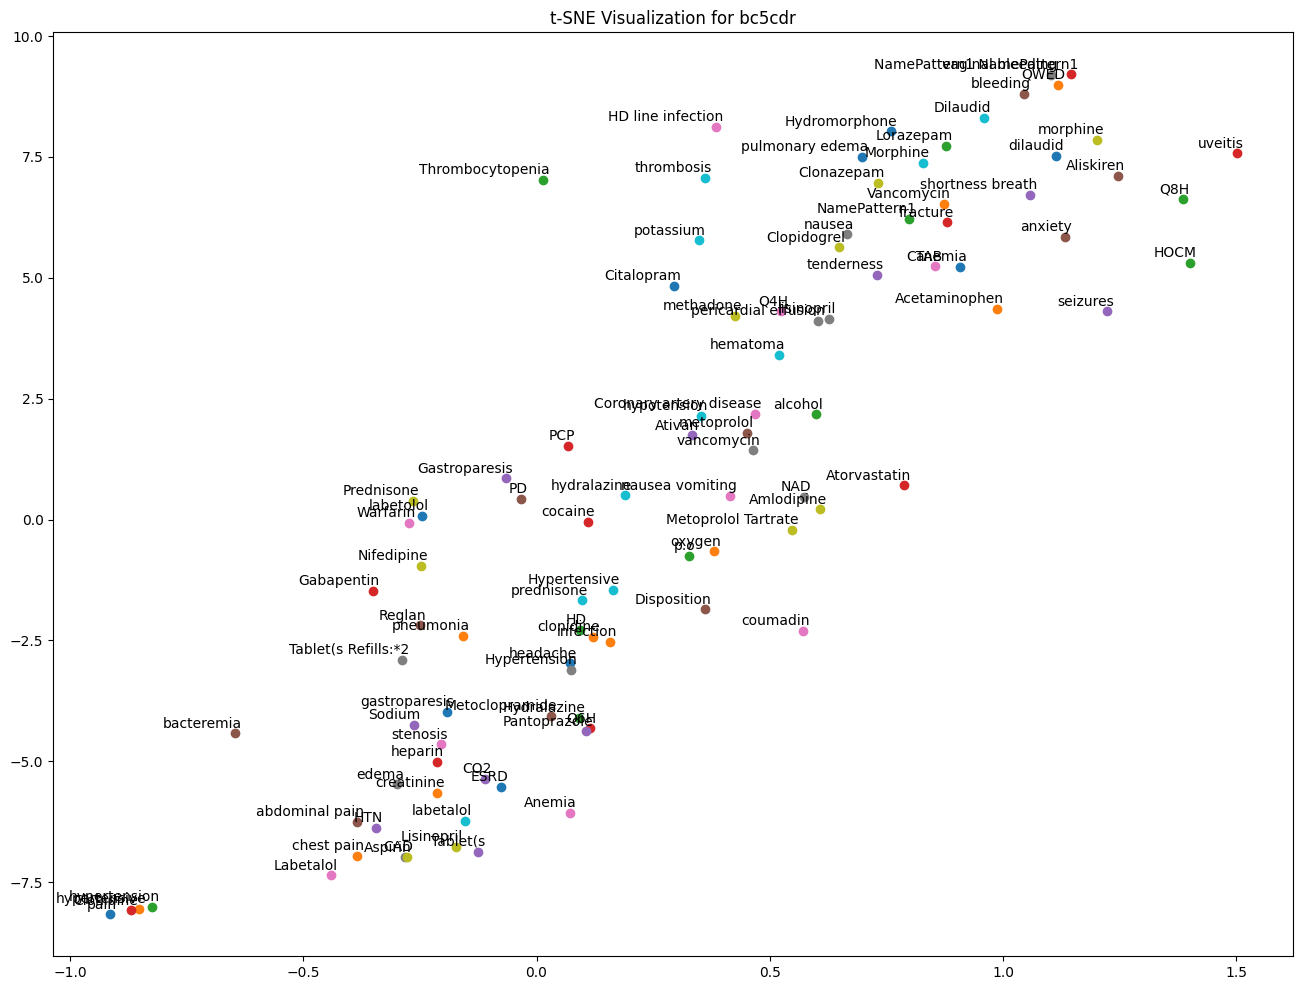

In [ ]:
tsne_plot(model_word2vec_bc5cdr,np.array(list(model_word2vec_bc5cdr.wv.key_to_index.keys())), 100, 'bc5cdr')

### BlueBert


In [24]:
# Visualization of notes filtered with SciSpacy using ClinicalBert
import numpy as np
import torch
from sklearn.manifold import TSNE
import string
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer, BertModel

# Load the BERT model and tokenizer
model_name = "bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12"
tokenizer = AutoTokenizer.from_pretrained(model_name)
blue_bert_model = BertModel.from_pretrained(model_name)
blue_bert_model.eval()

# Set first note as text
doc = nlp_SciSpaCy(patients_df_SciSpaCy['Processed_Text'][0])
corpus=[]
for ent in doc.ents:
    corpus.append(ent.text)
input_text =   ' '.join(corpus)

input_tokens = input_text.split()
word_embs = []

for token in input_tokens:
    # Check if the token is a valid word
    if token not in string.punctuation:
        # Encode the token using the BERT model
        inputs = tokenizer(token, return_tensors="pt")
        with torch.no_grad():
            outputs = blue_bert_model(**inputs)
        token_emb = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        word_embs.append(token_emb)


525


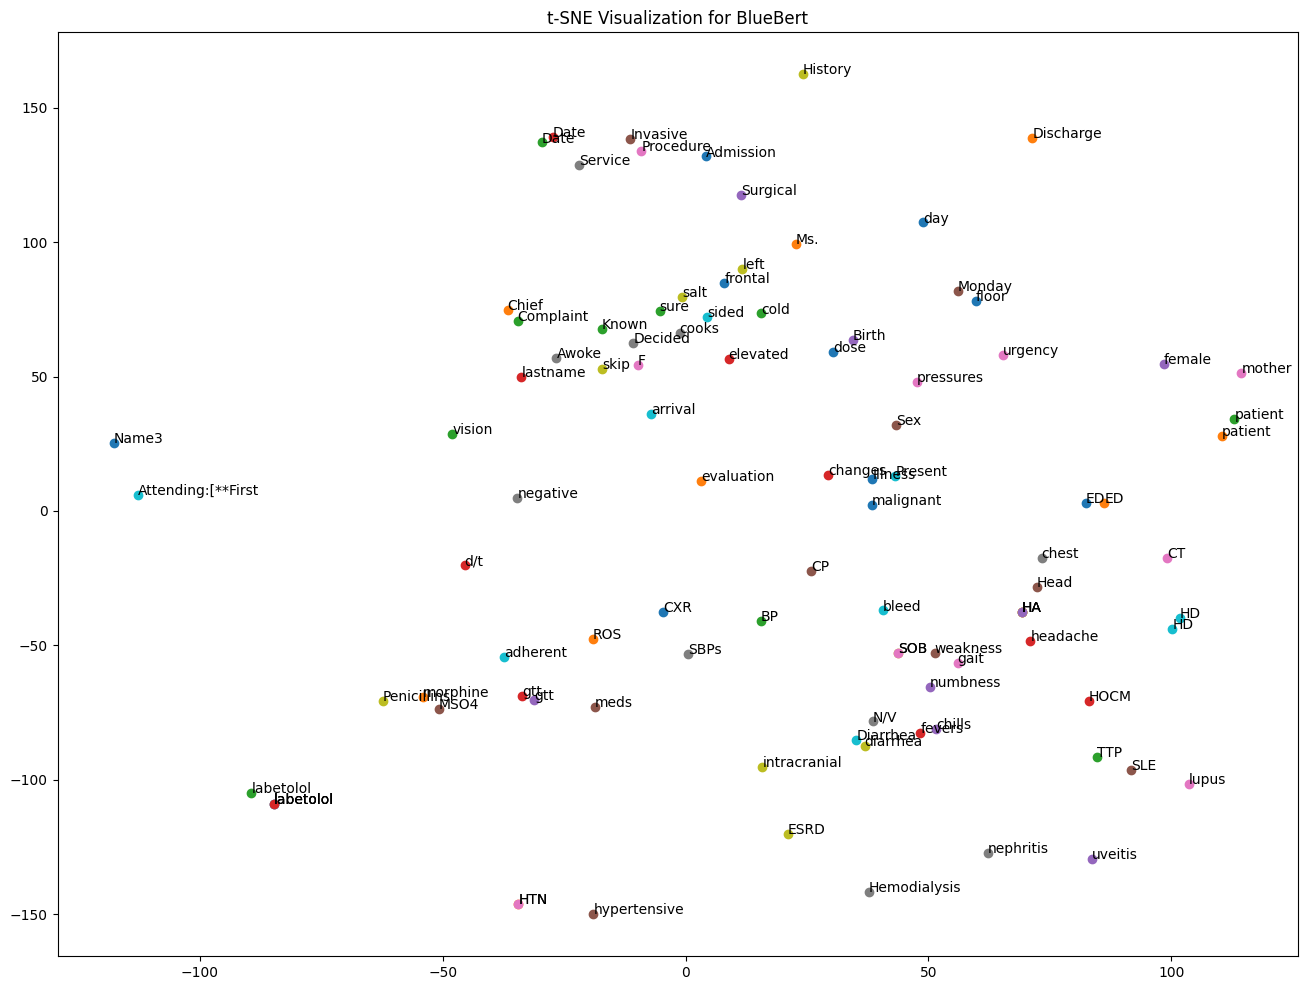

In [25]:
# Perform t-SNE dimensionality reduction
tsne_model = TSNE(n_components=2, perplexity=10, random_state=42)
word_embs_2d = tsne_model.fit_transform(np.array(word_embs))
print(len(word_embs_2d))
# Create a scatter plot of the word embeddings in 2D space
plt.figure(figsize=(16,12))
for i in range(100):
    plt.scatter(word_embs_2d[i, 0], word_embs_2d[i, 1])
    plt.annotate(input_tokens[i], (word_embs_2d[i, 0], word_embs_2d[i, 1]))

plt.title(f"t-SNE Visualization for BlueBert")
plt.show()

### MedSpacy Visualization Using SciSpaCy-Processed Data.

In [ ]:
!pip install medspacy

In [3]:
import medspacy
from spacy import displacy
from medspacy.ner import TargetRule
from medspacy.visualization import visualize_ent

# Load MedspaCy NLP pipeline
nlp_medspacy = medspacy.load()

# Add rules for target concept extraction
target_matcher = nlp_medspacy.get_pipe("medspacy_target_matcher")
# Define custom rules for better entity detection
target_rules = [
    TargetRule("hyperlipidemia", "DISEASE"),
    TargetRule("O2", "CHEMICAL"),
    TargetRule("FiO2", "CHEMICAL"),
    TargetRule("hypertension", "DISEASE"),
    TargetRule("hypertensive urgency", "DISEASE"),
    TargetRule("obesity", "CONDITION"),
    TargetRule("cardiac", "DISEASE"),
    TargetRule("SLE", "DISEASE"),
    TargetRule("lupus nephritis", "DISEASE"),
    TargetRule("ESRD", "DISEASE"),
    TargetRule("dialysis", "TREATMENT"),
    TargetRule("hemodialysis", "TREATMENT"),
    TargetRule("SBP", "MEASUREMENT"),
    TargetRule("HR", "MEASUREMENT"),
    TargetRule("TPN", "TREATMENT"),
    TargetRule("Prednisone", "MEDICATION"),
    TargetRule("Lisinopril", "MEDICATION"),
    TargetRule("Labetalol", "MEDICATION"),
    TargetRule("Clonidine", "MEDICATION"),
    TargetRule("Valsartan", "MEDICATION"),
    TargetRule("Sevelamer", "MEDICATION"),
    TargetRule("Atropine", "MEDICATION"),
    TargetRule("Morphine sulfate", "MEDICATION"),
    TargetRule("Diarrhea", "SYMPTOM"),
    TargetRule("Headache", "SYMPTOM"),
    TargetRule("nausea", "SYMPTOM"),
    TargetRule("vomiting", "SYMPTOM"),
    TargetRule("shortness of breath", "SYMPTOM"),
    TargetRule("fever", "SYMPTOM"),
    TargetRule("chills", "SYMPTOM")
]

target_matcher.add(target_rules)

for i in range(0, len(patients_df_SciSpaCy)):
  # Process the shift note
  doc = nlp_medspacy(patients_df_SciSpaCy['Processed_Text'][i])
  # visulize
  visualize_ent(doc)
  print("****************************")

****************************


In [8]:
#Build corpus
corpus_medspacy = build_corpus(patients_df_SciSpaCy, nlp_medspacy)

In [16]:
from gensim.models import Word2Vec
model_word2vec_medspacy = Word2Vec(corpus_medspacy, min_count=3, window=2, vector_size=100)

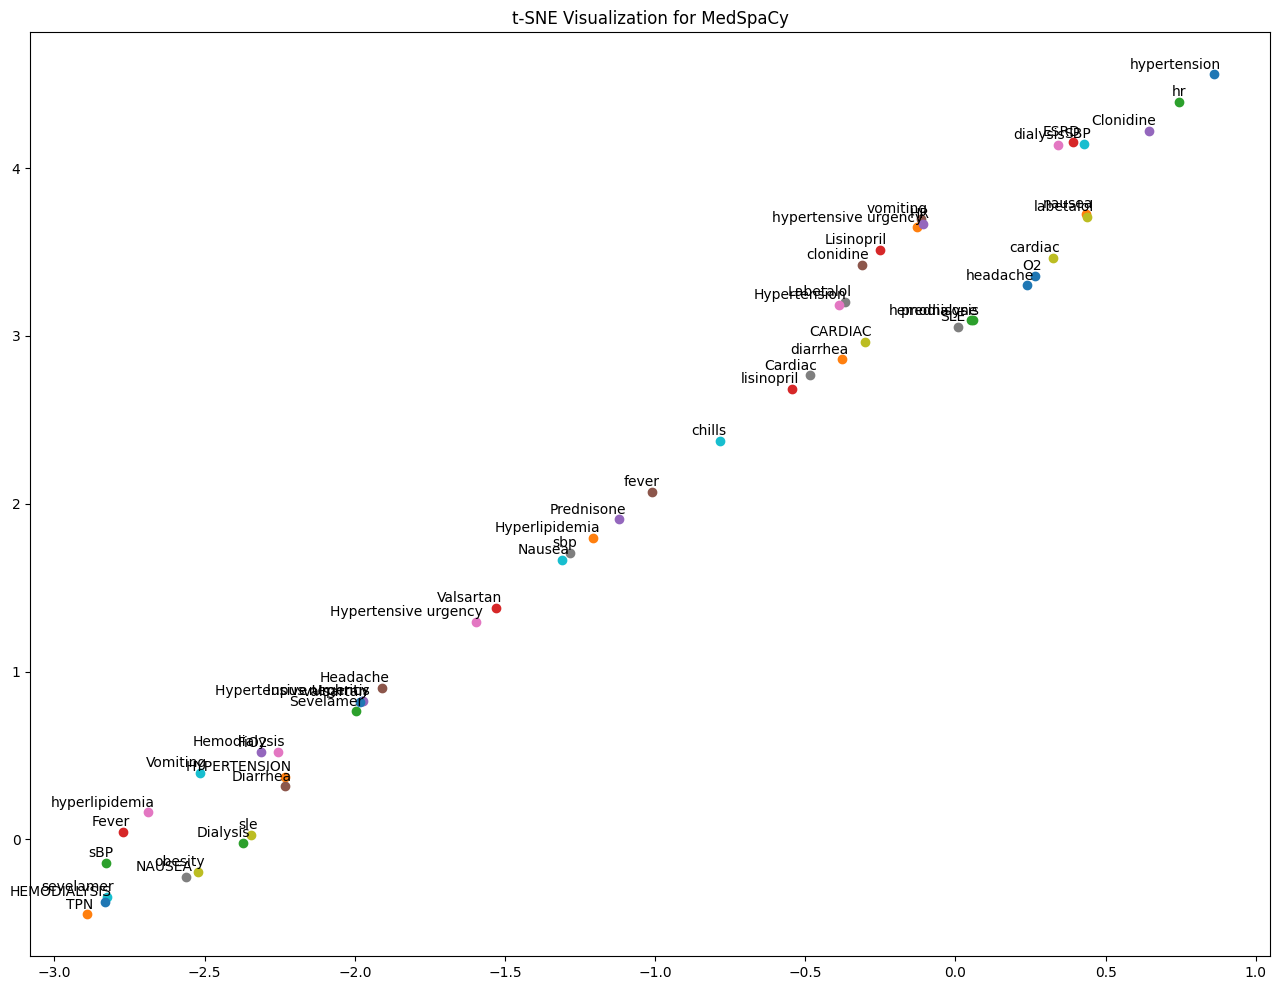

In [17]:
tsne_plot(model_word2vec_medspacy,np.array(list(model_word2vec_medspacy.wv.key_to_index.keys())), 100, 'MedSpaCy')